In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import random
import os
import pandas as pd
from folium import FeatureGroup


Catchment polygons are provided as GeoJSON files, an open standard format to share geographic features. Please note: catchment polygons do not exist for all GRDC stations particularly for those which came to the GRDC dataset after 2011, when the majority of polygons were delineated.

### 📌 Key Field Descriptions

| Field Name   | Meaning                                                                 |
|--------------|-------------------------------------------------------------------------|
| `lat_org`    | Original (official) latitude of the gauging station (from GRDC).        |
| `long_org`   | Original longitude of the station.                                      |
| `lat_pp`     | Latitude of the pour point (where flow exits the catchment).            |
| `long_pp`    | Longitude of the pour point.                                            |
| `grdc_no`    | Unique GRDC station identifier.                                         |
| `river`      | Name of the river where the station is located.                         |
| `station`    | Name of the gauging station.                                            |
| `area`       | Reported catchment area in square kilometers.                           |
| `altitude`   | Elevation of the station in meters above sea level.                    |
| `dist_km`    | Distance (in km) between original station location and pour point.      |
| `area_calc`  | Calculated catchment area based on geometry (for verification).         |
| `quality`    | Quality rating of the catchment delineation (e.g., high, medium, low).  |
| `type`       | Type of catchment delineation or data source.                           |
| `comment`    | Additional notes or metadata about the station.                         |
| `source`     | Data source (e.g., GRDC, custom delineation, etc.).                     |
| `geometry`   | Polygon geometry of the catchment area.                                 |


In [29]:
# Define the base input directory
base_dir = 'data_grdc_hydro_capp/input'

# Initialize a list to hold all GeoDataFrames
gdfs = []

# Walk through all directories under 'input'
for root, dirs, files in os.walk(base_dir):
    if 'stationbasins.geojson' in files:
        file_path = os.path.join(root, 'stationbasins.geojson')
        try:
            gdf = gpd.read_file(file_path)
            gdfs.append(gdf)
            print(f"Loaded: {file_path} with {len(gdf)} features.")
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")

# Merge all GeoDataFrames
if gdfs:
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
    print(f"Total merged features: {len(merged_gdf)}")
else:
    print("No 'stationbasins.geojson' files found.")

Loaded: data_grdc_hydro_capp/input/sao_tome/stationbasins.geojson with 8 features.
Loaded: data_grdc_hydro_capp/input/gabon/stationbasins.geojson with 19 features.
Loaded: data_grdc_hydro_capp/input/democroatic_republic_congo/stationbasins.geojson with 6 features.
Loaded: data_grdc_hydro_capp/input/central_africa/stationbasins.geojson with 24 features.
Loaded: data_grdc_hydro_capp/input/angola/stationbasins.geojson with 19 features.
Loaded: data_grdc_hydro_capp/input/chad/stationbasins.geojson with 15 features.
Loaded: data_grdc_hydro_capp/input/republic_congo/stationbasins.geojson with 20 features.
Loaded: data_grdc_hydro_capp/input/cameroon/stationbasins.geojson with 43 features.
Loaded: data_grdc_hydro_capp/input/burundi/stationbasins.geojson with 51 features.
Total merged features: 205


In [31]:
def plot_catchment_map(gdf):

    def add_river_layer(map_object, river_geojson_path):
        rivers = gpd.read_file(river_geojson_path)

        folium.GeoJson(
            rivers,
            name="Rivers",
            style_function=lambda x: {
                'color': 'blue',
                'weight': 2,
                'opacity': 0.8
            }
        ).add_to(map_object)

    def random_color():
        """Generate a random HEX color."""
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))


    # Get center of the map from average coordinates
    center_lat = gdf['lat_org'].mean()
    center_lon = gdf['long_org'].mean()

    # Create base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='CartoDB positron')

    # Add catchments with popup info
    for _, row in gdf.iterrows():
        color = random_color()
        fg = FeatureGroup(name=row['station'])

        # Create popup with full station info
        popup_html = f"""
        <b>Station:</b> {row['station']}<br>
        <b>River:</b> {row['river']}<br>
        <b>GRDC No:</b> {row['grdc_no']}<br>
        <b>Area (Reported):</b> {row['area']} km²<br>
        <b>Area (Calculated):</b> {row['area_calc']} km²<br>
        <b>Altitude:</b> {row['altitude']} m<br>
        <b>Lat (Original):</b> {row['lat_org']}<br>
        <b>Lon (Original):</b> {row['long_org']}<br>
        <b>Lat (Pour Point):</b> {row['lat_pp']}<br>
        <b>Lon (Pour Point):</b> {row['long_pp']}<br>
        <b>Distance to Pour Point:</b> {row['dist_km']} km<br>
        <b>Quality:</b> {row['quality']}<br>
        <b>Type:</b> {row['type']}<br>
        <b>Source:</b> {row['source']}<br>
        <b>Comment:</b> {row['comment']}
        """

        folium.GeoJson(
            row['geometry'],
            name=row['station'],
            tooltip=row['station'],
            popup=folium.Popup(popup_html, max_width=300),
            style_function=lambda feature, col=color: {
                'fillColor': col,
                'color': col,
                'weight': 2,
                'fillOpacity': 0.5
            }
        ).add_to(fg)

        # Add station marker (original location)
        folium.Marker(
            location=[row['lat_org'], row['long_org']],
            popup=folium.Popup(popup_html, max_width=350),
            tooltip=row['station'],
            icon=folium.Icon(color='blue', icon='tint', prefix='fa')
        ).add_to(fg)
        fg.add_to(m)

    # Add Layer Control to toggle catchments
    folium.LayerControl(collapsed=False).add_to(m)

    return m

catchment_map = plot_catchment_map(merged_gdf)
catchment_map.save('catchment_map.html')

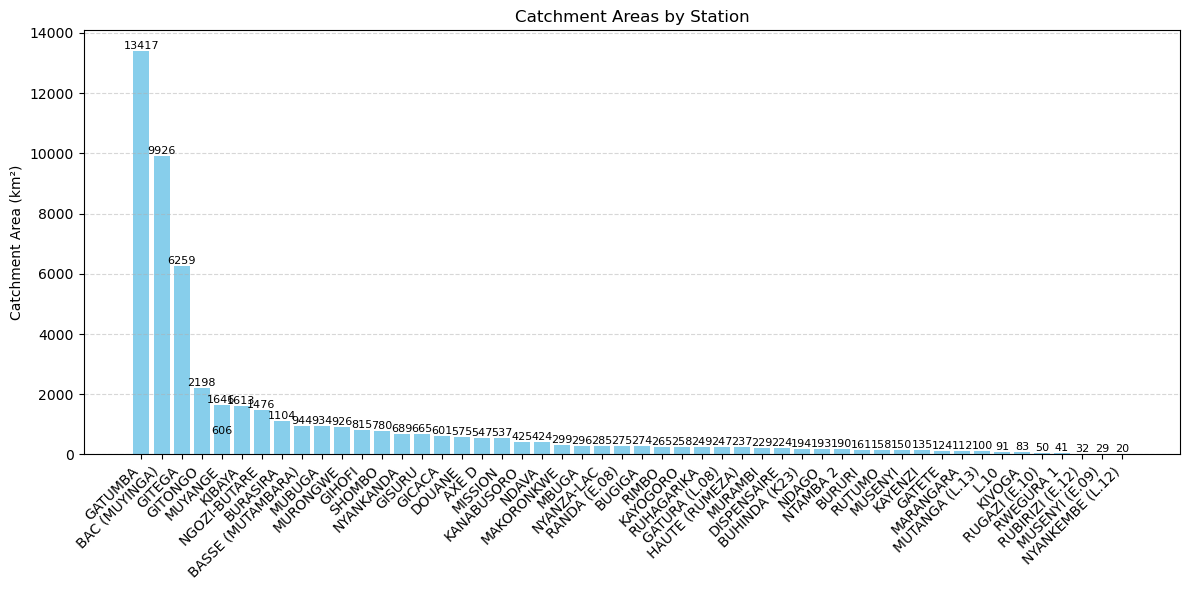

In [32]:
def plot_catchment_areas(gdf):
    """
    Plot a bar chart of catchment areas per station in km².

    Parameters:
        gdf (GeoDataFrame): GeoDataFrame with columns 'station' and 'area_calc'.
    """
    # Convert area to km² if not already
    gdf = gdf.copy()
    gdf['area_km2'] = gdf['area_calc']  # assume already in km²; if in m² use (gdf['area_calc'] / 1e6)

    # Sort by area for nicer plot
    gdf_sorted = gdf.sort_values(by='area_km2', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(gdf_sorted['station'], gdf_sorted['area_km2'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Catchment Area (km²)")
    plt.title("Catchment Areas by Station")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.0f}", ha='center', va='bottom', fontsize=8)

    plt.show()

plot_catchment_areas(gdf)